In [ ]:
import os
from PIL import Image

# Define paths for the dataset and subfolders
lab_coat_folder = '/content/drive/MyDrive/Lab_Coat_Dataset/White_Lab_Coats'
false_positive_folder = '/content/drive/MyDrive/Lab_Coat_Dataset/False_Positive_Images'

# Define paths for the output resized image folders (new separate folders)
lab_coat_resized_folder = '/content/drive/MyDrive/Lab_Coat_Dataset/Resized_Lab_Coat_Images'
false_positive_resized_folder = '/content/drive/MyDrive/Lab_Coat_Dataset/Resized_False_Positive_Images'

# Define the output size for resizing
resize_size = (512, 512)  # Change the dimensions as required

# Function to create a separate folder for resized images
def create_resized_folder(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    return folder_path

# Function to resize images and save them in the separate folder
def resize_images_in_folder(input_folder, output_folder):
    # Ensure the output folder exists
    create_resized_folder(output_folder)

    # Loop through each image file in the folder
    for filename in os.listdir(input_folder):
        if filename.endswith(('.jpg', '.png', '.jpeg')):  # Add other image formats if necessary
            image_path = os.path.join(input_folder, filename)
            img = Image.open(image_path)

            # Resize the image
            img_resized = img.resize(resize_size)

            # Save the resized image into the new output folder
            resized_image_path = os.path.join(output_folder, filename)
            img_resized.save(resized_image_path)  # Save resized image in the new folder

# Resize images in both folders and save to separate folders
resize_images_in_folder(lab_coat_folder, lab_coat_resized_folder)
resize_images_in_folder(false_positive_folder, false_positive_resized_folder)

print("Images resized and saved to separate folders successfully!")


Images resized and saved to separate folders successfully!


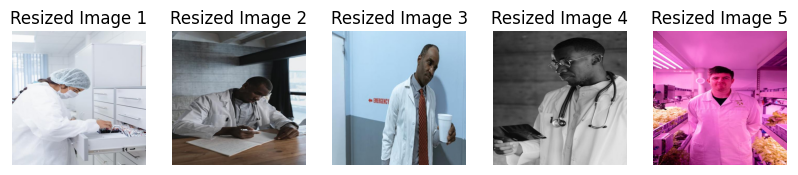

In [ ]:
import matplotlib.pyplot as plt
import os
from PIL import Image

# Function to display a few images from a folder
def display_images_from_folder(folder_path, num_images=5):
    # List all image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

    # Limit to the number of images you want to display
    image_files = image_files[:num_images]

    # Plot each image
    plt.figure(figsize=(10, 10))
    for idx, image_file in enumerate(image_files):
        image_path = os.path.join(folder_path, image_file)
        img = Image.open(image_path)

        plt.subplot(1, num_images, idx + 1)
        plt.imshow(img)
        plt.title(f"Resized Image {idx+1}")
        plt.axis('off')  # Hide axes for better visualization

    plt.show()

# Specify paths to the resized image folders
lab_coat_resized_folder = '/content/drive/MyDrive/Lab_Coat_Dataset/Resized_Lab_Coat_Images'  # Path to the folder for resized lab coat images
false_positive_resized_folder = '/content/drive/MyDrive/Lab_Coat_Dataset/Resized_False_Positive_Images'  # Path to the folder for resized false positive images

# Display a few images from the resized lab coat folder
display_images_from_folder(lab_coat_resized_folder, num_images=5)  # Change num_images to see more or fewer images


In [ ]:
!pip install rembg

NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968

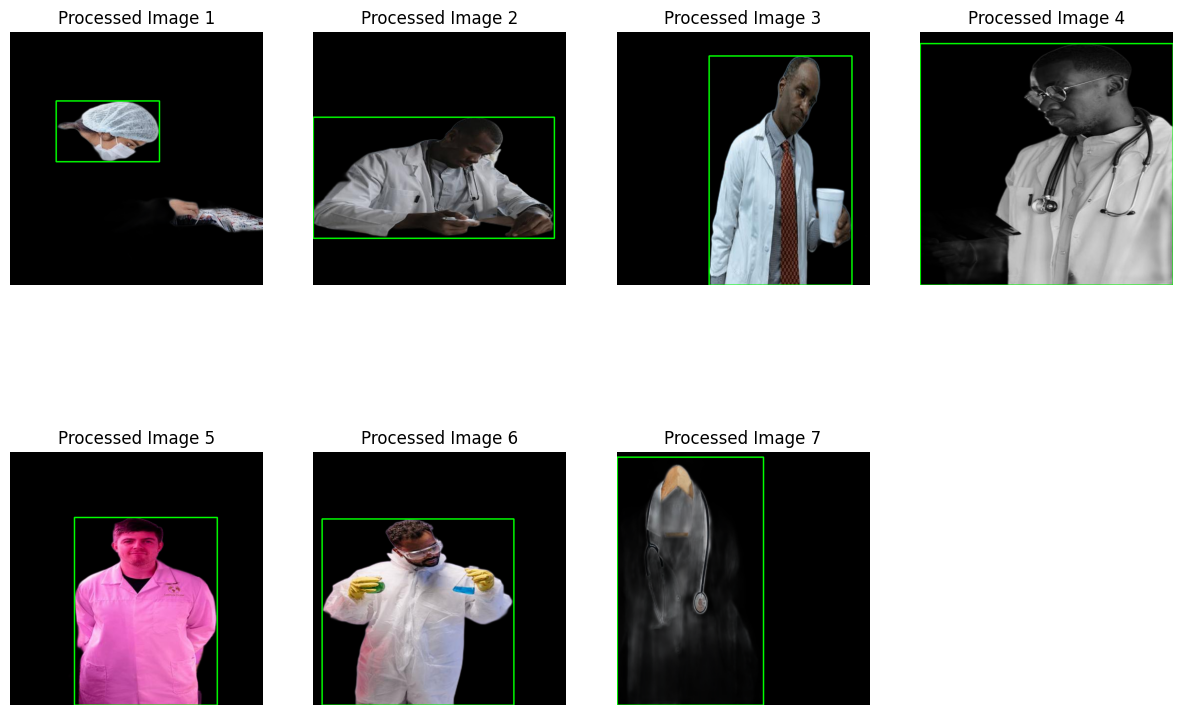

Successfully processed 96 images.


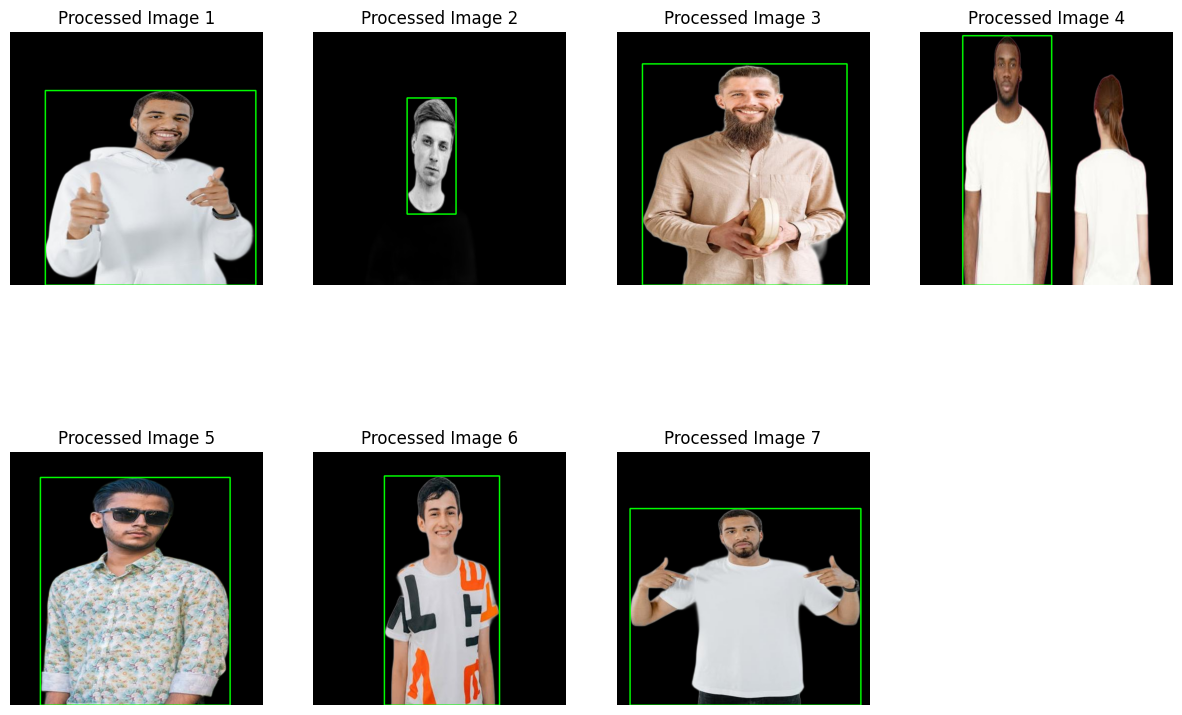

Successfully processed 90 images.


In [ ]:
import os
import io
import numpy as np
import cv2
from PIL import Image
from rembg import remove
import matplotlib.pyplot as plt

# Function to process images
def process_images(folder_path, label, output_folder):
    # Create output folder for .txt files if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # List all image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

    # List to store processed images for display
    processed_images = []

    # Initialize counters for successful and failed image processing
    successful_count = 0
    failed_images = []

    for image_file in image_files:
        try:
            input_path = os.path.join(folder_path, image_file)

            # Open the original image and ensure it's in RGB mode
            original_image = Image.open(input_path).convert("RGB")

            # Remove background
            with open(input_path, "rb") as img_file:
                input_image = img_file.read()
            output_image = remove(input_image)

            # Convert the background-removed image from byte stream back to a PIL image
            removed_bg_image = Image.open(io.BytesIO(output_image)).convert("RGB")

            # Convert to numpy array for manipulation
            removed_bg_image_np = np.array(removed_bg_image)

            # Convert the image to grayscale to identify the non-black region
            gray = cv2.cvtColor(removed_bg_image_np, cv2.COLOR_RGB2GRAY)

            # Threshold the grayscale image to create a binary image (object vs background)
            _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

            # Find contours to detect the bounding box around the object
            contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Initialize bounding box coordinates
            bbox = None

            if contours:
                largest_contour = max(contours, key=cv2.contourArea)
                # Get bounding box coordinates for the largest contour
                x, y, w, h = cv2.boundingRect(largest_contour)

                # Store bounding box coordinates
                bbox = (x, y, w, h)

                # Draw a bounding box on the image
                cv2.rectangle(removed_bg_image_np, (x, y), (x + w, y + h), (0, 255, 0), 2)

            # Save label and bounding box coordinates to a .txt file
            if bbox:
                txt_file_path = os.path.join(output_folder, f"{os.path.splitext(image_file)[0]}.txt")
                with open(txt_file_path, "w") as f:
                    f.write(f"{label} {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}\n")  # Format: label x y w h

                # Increment the count of successful images
                successful_count += 1
            else:
                # If no bounding box is found, log the failed image
                failed_images.append(image_file)

            # Ensure the image is added for displaying
            processed_images.append(removed_bg_image_np)

        except Exception as e:
            print(f"Error processing {image_file}: {e}")
            failed_images.append(image_file)

    # Display the first 7 processed images with bounding boxes
    plt.figure(figsize=(15, 10))
    for i, img in enumerate(processed_images[:7]):  # Only display the first 7 images
        plt.subplot(2, 4, i + 1)
        plt.imshow(img)  # Directly use the RGB image
        plt.axis('off')
        plt.title(f"Processed Image {i + 1}")
    plt.show()

    # Print out the results of the processing
    print(f"Successfully processed {successful_count} images.")
    if failed_images:
        print(f"Failed to process {len(failed_images)} images: {failed_images}")

# Specify paths to the resized image folders
lab_coat_resized_folder = '/content/drive/MyDrive/Lab_Coat_Dataset/Resized_Lab_Coat_Images'
false_positive_resized_folder = '/content/drive/MyDrive/Lab_Coat_Dataset/Resized_False_Positive_Images'

# Create output folders for .txt files
lab_coat_output_folder = '/content/drive/MyDrive/Lab_Coat_Dataset/Lab_Coat_Labels'
false_positive_output_folder = '/content/drive/MyDrive/Lab_Coat_Dataset/False_Positive_Labels'

# Process images from both folders
process_images(lab_coat_resized_folder, label=1, output_folder=lab_coat_output_folder)
process_images(false_positive_resized_folder, label=0, output_folder=false_positive_output_folder)


In [ ]:
import os
import shutil

# Specify the input folders for images and labels
lab_coat_resized_folder = '/content/drive/MyDrive/Lab_Coat_Dataset/Resized_Lab_Coat_Images'
false_positive_resized_folder = '/content/drive/MyDrive/Lab_Coat_Dataset/Resized_False_Positive_Images'
lab_coat_labels_folder = '/content/drive/MyDrive/Lab_Coat_Dataset/Lab_Coat_Labels'
false_positive_labels_folder = '/content/drive/MyDrive/Lab_Coat_Dataset/False_Positive_Labels'

# Create the new output folder for renamed images and .txt files
train_folder = '/content/drive/MyDrive/Lab_Coat_Dataset/train_folder'
os.makedirs(train_folder, exist_ok=True)

def rename_and_move_files(input_folder, labels_folder, start_index):
    """Rename and move image and .txt files from the input folder to the output folder."""
    # List all image files in the input folder
    image_files = [f for f in os.listdir(input_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]

    # Sort files to maintain order
    image_files.sort()

    # Rename and move image files
    for i, image_file in enumerate(image_files, start=start_index):
        new_image_name = f"image_{i}.jpg"  # Change the extension as needed
        old_image_path = os.path.join(input_folder, image_file)
        new_image_path = os.path.join(train_folder, new_image_name)

        # Move and rename the image file
        shutil.copy(old_image_path, new_image_path)

        # Rename and move the corresponding .txt file
        label_file_name = os.path.splitext(image_file)[0] + '.txt'
        old_label_path = os.path.join(labels_folder, label_file_name)
        new_label_name = f"image_{i}.txt"
        new_label_path = os.path.join(train_folder, new_label_name)

        # Check if the label file exists and move it
        if os.path.exists(old_label_path):
            shutil.copy(old_label_path, new_label_path)

    # Return the next index for the next folder
    return start_index + len(image_files)

# Start renaming from 1
current_index = 1

# Rename and move files from the lab coat resized folder and its labels
current_index = rename_and_move_files(lab_coat_resized_folder, lab_coat_labels_folder, current_index)

# Rename and move files from the false positive resized folder and its labels
rename_and_move_files(false_positive_resized_folder, false_positive_labels_folder, current_index)

print("Renaming and moving completed!")


Renaming and moving completed!


In [ ]:
import os
import shutil

# Paths
train_folder = "/content/drive/MyDrive/Lab_Coat_Dataset/train_folder"  # Your current train folder containing both images and txt files
images_folder = os.path.join(train_folder, "total_images")  # New folder for images
text_files_folder = os.path.join(train_folder, "text_files")  # New folder for text files

# Create the new directories for images and text files if they don't exist
os.makedirs(images_folder, exist_ok=True)
os.makedirs(text_files_folder, exist_ok=True)

# Iterate over all files in the train folder
for filename in os.listdir(train_folder):
    file_path = os.path.join(train_folder, filename)

    # Check if it's a file (not a directory)
    if os.path.isfile(file_path):
        if filename.endswith((".jpg", ".jpeg", ".png")):  # Image files (add other formats if needed)
            # Move image files to total_images folder
            shutil.move(file_path, os.path.join(images_folder, filename))
            print(f"Moved image: {filename}")
        elif filename.endswith(".txt"):  # Text annotation files
            # Move text files to text_files folder
            shutil.move(file_path, os.path.join(text_files_folder, filename))
            print(f"Moved txt file: {filename}")

print("Files separated successfully!")


In [ ]:
import os
import shutil
import random

def split_train_val(train_folder, val_folder, split_ratio=0.2):
    # Create validation folder if it doesn't exist
    os.makedirs(val_folder, exist_ok=True)

    # List all image files in the train folder (considering common image formats)
    image_files = [f for f in os.listdir(train_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]

    # Ensure there are corresponding .txt files
    txt_files = [f"{os.path.splitext(f)[0]}.txt" for f in image_files if os.path.isfile(os.path.join(train_folder, f"{os.path.splitext(f)[0]}.txt"))]

    # Filter image files to those with matching .txt files
    image_files = [f for f in image_files if f"{os.path.splitext(f)[0]}.txt" in txt_files]

    # Shuffle the image files to randomize selection
    random.shuffle(image_files)

    # Calculate the number of images to move to the validation set
    val_count = int(len(image_files) * split_ratio)

    # Select images for validation
    val_images = image_files[:val_count]

    # Move the selected images and their corresponding .txt files to val_folder
    for image_file in val_images:
        base_name = os.path.splitext(image_file)[0]
        txt_file = f"{base_name}.txt"

        # Define source and destination paths
        image_src_path = os.path.join(train_folder, image_file)
        txt_src_path = os.path.join(train_folder, txt_file)
        image_dest_path = os.path.join(val_folder, image_file)
        txt_dest_path = os.path.join(val_folder, txt_file)

        # Move image file
        if os.path.exists(image_src_path):
            shutil.move(image_src_path, image_dest_path)

        # Move corresponding .txt file
        if os.path.exists(txt_src_path):
            shutil.move(txt_src_path, txt_dest_path)

    print(f"Moved {val_count} images and their corresponding .txt files to {val_folder}.")

# Specify the paths
train_folder = '/content/drive/MyDrive/Lab_Coat_Dataset/train_folder'
val_folder = '/content/drive/MyDrive/Lab_Coat_Dataset'

# Call the function to split and move 20% of the data to the validation folder
split_train_val(train_folder, val_folder, split_ratio=0.2)


Moved 37 images and their corresponding .txt files to /content/drive/MyDrive/val_folder.


In [ ]:
import os
import shutil

# Define the paths for your original train and validation folders
train_folder = "/content/drive/MyDrive/Lab_Coat_Dataset/train_folder"
val_folder = "/content/drive/MyDrive/Lab_Coat_Dataset/val_folder"

# Define paths for new folders
train_images_folder = os.path.join(train_folder, "train_images")
train_texts_folder = os.path.join(train_folder, "train_textfiles")
val_images_folder = os.path.join(val_folder, "val_images")
val_texts_folder = os.path.join(val_folder, "val_textfiles")

# Create new folders for training images and texts
os.makedirs(train_images_folder, exist_ok=True)
os.makedirs(train_texts_folder, exist_ok=True)

# Create new folders for validation images and texts
os.makedirs(val_images_folder, exist_ok=True)
os.makedirs(val_texts_folder, exist_ok=True)

# Move training image files to the new folder
for filename in os.listdir(train_folder):
    if filename.endswith((".jpg", ".jpeg", ".png")):
        shutil.move(os.path.join(train_folder, filename), os.path.join(train_images_folder, filename))
    elif filename.endswith(".txt"):
        shutil.move(os.path.join(train_folder, filename), os.path.join(train_texts_folder, filename))

# Move validation image files to the new folder
for filename in os.listdir(val_folder):
    if filename.endswith((".jpg", ".jpeg", ".png")):
        shutil.move(os.path.join(val_folder, filename), os.path.join(val_images_folder, filename))
    elif filename.endswith(".txt"):
        shutil.move(os.path.join(val_folder, filename), os.path.join(val_texts_folder, filename))

print("Files have been separated into train and validation folders.")


Files have been separated into train and validation folders.


In [ ]:
import os
import json
import cv2

# Paths to your dataset
image_dir = "/content/drive/MyDrive/Lab_Coat_Dataset/train_folder/train_images"
annotation_dir = "/content/drive/MyDrive/Lab_Coat_Dataset/train_folder/train_textfiles"
output_json = "/content/drive/MyDrive/Lab_Coat_Dataset/train_folder/annotations_coco.json"

# Define your categories (example for two categories)
categories = [
    {"id": 1, "name": "lab_coat"},
    {"id": 2, "name": "false_positive"}  # Add more if necessary
]

# Prepare the data structure
coco_dataset = {
    "images": [],
    "annotations": [],
    "categories": categories
}

annotation_id = 1  # ID counter for annotations
image_id = 1       # ID counter for images

# Iterate through the images and their corresponding YOLO annotations
for image_file in os.listdir(image_dir):
    if image_file.endswith((".jpg", ".jpeg", ".png")):
        # Read the image to get its width and height
        image_path = os.path.join(image_dir, image_file)
        image = cv2.imread(image_path)
        height, width, _ = image.shape

        # Add image entry to COCO dataset
        coco_image = {
            "id": image_id,
            "file_name": image_file,
            "width": width,
            "height": height
        }
        coco_dataset["images"].append(coco_image)

        # Find corresponding YOLO annotation file
        annotation_file = os.path.splitext(image_file)[0] + ".txt"
        annotation_path = os.path.join(annotation_dir, annotation_file)

        if os.path.exists(annotation_path):
            # Read YOLO annotation file
            with open(annotation_path, "r") as f:
                lines = f.readlines()

                # Parse each line in the YOLO annotation
                for line in lines:
                    class_id, x_min, y_min, b_box_width, b_box_height = map(float, line.strip().split())

                    # Convert pixel coordinates to YOLO format
                    bbox_width = x_min + b_box_width  # Bottom-right x ->(x_max)
                    bbox_height = y_min + b_box_height   # Bottom-right y ->(y_max)


                    # Create the annotation entry
                    coco_annotation = {
                        "id": annotation_id,
                        "image_id": image_id,
                        "category_id": int(class_id) + 1,  # Category IDs start from 1 in COCO
                        "bbox": [x_min, y_min, bbox_width, bbox_height],  # Keep original for COCO format
                        "area": b_box_width * b_box_height,
                        "iscrowd": 0
                    }
                    coco_dataset["annotations"].append(coco_annotation)
                    annotation_id += 1

        image_id += 1

# Save the COCO annotations to a JSON file
with open(output_json, "w") as outfile:
    json.dump(coco_dataset, outfile, indent=4)

print(f"COCO annotation file created: {output_json}")

# Paths to your dataset
image_dir = "/content/drive/MyDrive/Lab_Coat_Dataset/val_folder/val_images"
annotation_dir = "/content/drive/MyDrive/Lab_Coat_Dataset/val_folder/val_textfiles"
output_json = "/content/drive/MyDrive/Lab_Coat_Dataset/val_folder/annotations_coco.json"


COCO annotation file created: /content/drive/MyDrive/Lab_Coat_Dataset/train_folder/annotations_coco.json


In [ ]:
import os
import json
import cv2

# Paths to your dataset
image_dir = "/content/drive/MyDrive/Lab_Coat_Dataset/val_folder/val_images"
annotation_dir = "/content/drive/MyDrive/Lab_Coat_Dataset/val_folder/val_textfiles"
output_json = "/content/drive/MyDrive/Lab_Coat_Dataset/val_folder/annotations_coco.json"

# Define your categories (example for two categories)
categories = [
    {"id": 1, "name": "lab_coat"},
    {"id": 2, "name": "false_positive"}  # Add more if necessary
]

# Prepare the data structure
coco_dataset = {
    "images": [],
    "annotations": [],
    "categories": categories
}

annotation_id = 1  # ID counter for annotations
image_id = 1       # ID counter for images

# Iterate through the images and their corresponding YOLO annotations
for image_file in os.listdir(image_dir):
    if image_file.endswith((".jpg", ".jpeg", ".png")):
        # Read the image to get its width and height
        image_path = os.path.join(image_dir, image_file)
        image = cv2.imread(image_path)
        height, width, _ = image.shape

        # Add image entry to COCO dataset
        coco_image = {
            "id": image_id,
            "file_name": image_file,
            "width": width,
            "height": height
        }
        coco_dataset["images"].append(coco_image)

        # Find corresponding YOLO annotation file
        annotation_file = os.path.splitext(image_file)[0] + ".txt"
        annotation_path = os.path.join(annotation_dir, annotation_file)

        if os.path.exists(annotation_path):
            # Read YOLO annotation file
            with open(annotation_path, "r") as f:
                lines = f.readlines()

                # Parse each line in the YOLO annotation
                for line in lines:
                    class_id, x_min, y_min, b_box_width, b_box_height = map(float, line.strip().split())

                    # Convert pixel coordinates to YOLO format
                    bbox_width = x_min + b_box_width  # Bottom-right x ->(x_max)
                    bbox_height = y_min + b_box_height   # Bottom-right y ->(y_max)


                    # Create the annotation entry
                    coco_annotation = {
                        "id": annotation_id,
                        "image_id": image_id,
                        "category_id": int(class_id) + 1,  # Category IDs start from 1 in COCO
                        "bbox": [x_min, y_min, bbox_width, bbox_height],  # Keep original for COCO format
                        "area": b_box_width * b_box_height,
                        "iscrowd": 0
                    }
                    coco_dataset["annotations"].append(coco_annotation)
                    annotation_id += 1

        image_id += 1

# Save the COCO annotations to a JSON file
with open(output_json, "w") as outfile:
    json.dump(coco_dataset, outfile, indent=4)

print(f"COCO annotation file created: {output_json}")

COCO annotation file created: /content/drive/MyDrive/Lab_Coat_Dataset/val_folder/annotations_coco.json


In [ ]:
!pip install torch torchvision

In [ ]:
# Load model directly
from transformers import AutoImageProcessor, AutoModelForObjectDetection

processor = AutoImageProcessor.from_pretrained("PekingU/rtdetr_r18vd")
model = AutoModelForObjectDetection.from_pretrained("PekingU/rtdetr_r18vd")

In [ ]:
!pip install torch torchvision transformers datasets


INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.0 MB/s eta 0:00:00


**START FROM HERE**

In [ ]:
import os
import json
import torch
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForObjectDetection, AutoImageProcessor, Trainer, TrainingArguments

class CocoDataset(Dataset):
    def __init__(self, images_dir, annotations_file):
        self.images_dir = images_dir
        self.annotations = json.load(open(annotations_file))
        self.image_ids = [img['id'] for img in self.annotations['images']]

        # Create a dictionary mapping image_id to its annotations
        self.image_annotations = {}
        for annotation in self.annotations['annotations']:
            image_id = annotation['image_id']
            if image_id not in self.image_annotations:
                self.image_annotations[image_id] = []
            self.image_annotations[image_id].append(annotation)

        # Define transformations
        self.transform = transforms.Compose([
            transforms.Resize((640, 640)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_info = next(item for item in self.annotations['images'] if item['id'] == image_id)
        image_path = os.path.join(self.images_dir, image_info['file_name'])
        image = Image.open(image_path).convert("RGB")

        # Apply transformations if needed
        if self.transform:
            image = self.transform(image)

        # Get the corresponding annotations for the current image
        annotations = self.image_annotations[image_id]

        boxes = []
        class_labels = []

        for annotation in annotations:
            boxes.append(annotation['bbox'])  # Ensure format [x, y, width, height]
            class_labels.append(annotation['category_id'])  # Category ID or label as per annotations

        # Convert boxes and class_labels to tensors
        boxes = torch.tensor(boxes, dtype=torch.float32)  # Convert to float tensor
        class_labels = torch.tensor(class_labels, dtype=torch.int64)   # Convert to int tensor

        # Return a tuple (image, target dictionary with 'class_labels')
        return image, {'boxes': boxes, 'class_labels': class_labels}

# Define a custom collate_fn to handle the batch of data
def collate_fn(batch):
    images, targets = zip(*batch)
    return {
        'pixel_values': torch.stack(images),  # Stack images into a tensor
        'labels': targets  # Keep targets as a list of dictionaries
    }

# Load the model and processor
processor = AutoImageProcessor.from_pretrained("PekingU/rtdetr_r18vd")
model = AutoModelForObjectDetection.from_pretrained("PekingU/rtdetr_r18vd")

# Paths to your images and annotations
train_images_dir = '/content/drive/MyDrive/Lab_Coat_Dataset/train_folder/train_images'
val_images_dir = '/content/drive/MyDrive/Lab_Coat_Dataset/val_folder/val_images'
train_annotations_file = '/content/drive/MyDrive/Lab_Coat_Dataset/train_folder/annotations_coco.json'
val_annotations_file = '/content/drive/MyDrive/Lab_Coat_Dataset/val_folder/annotations_coco.json'

# Create datasets
train_dataset = CocoDataset(train_images_dir, train_annotations_file)
val_dataset = CocoDataset(val_images_dir, val_annotations_file)

# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)
# Define training arguments with L2 regularization, learning rate, and gradient clipping
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=1e-5,  # Adjust learning rate if needed
    per_device_train_batch_size=16,  # Adjust based on GPU capacity
    per_device_eval_batch_size=16,   # Adjust based on GPU capacity
    num_train_epochs=50,  # Number of epochs
    weight_decay=0.01,  # L2 regularization (Weight Decay)
    max_grad_norm=1.0  # Gradient clipping
)


# Create the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collate_fn
)
# Start training
trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


TrainOutput(global_step=500, training_loss=37003.852, metrics={'train_runtime': 733.5855, 'train_samples_per_second': 10.156, 'train_steps_per_second': 0.682, 'total_flos': 1.10699898273792e+18, 'train_loss': 37003.852, 'epoch': 50.0})

In [ ]:
# Define a directory to save your trained model
output_dir = "/content/drive/MyDrive/Lab_Coat_Dataset/RT_DETR_trained_model"

# Save the trained model
model.save_pretrained(output_dir)

# Save the processor (AutoImageProcessor) used for preprocessing the data
processor.save_pretrained(output_dir)


['/content/drive/MyDrive/Lab_Coat_Dataset/RT_DETR_trained_model/preprocessor_config.json']

In [ ]:
from transformers import AutoModelForObjectDetection, AutoImageProcessor
import cv2
import torch
from google.colab.patches import cv2_imshow

# Set your model directory path
model_path = "/content/drive/MyDrive/Lab_Coat_Dataset/RT_DETR_trained_model"  # Update this path

# Load the processor and model
processor = AutoImageProcessor.from_pretrained(model_path)
model = AutoModelForObjectDetection.from_pretrained(model_path)

# Path to your external video file
video_path = "/content/drive/MyDrive/Yolo_Test_Video/Perfect_LabCoat_Video.mp4"  # Update this path

# Open the video file
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

while True:
    ret, frame = cap.read()
    if not ret:
        break  # Exit the loop when there are no more frames

    # Preprocess the frame
    inputs = processor(frame, return_tensors="pt")

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)

    # Post-process the outputs
    target_sizes = torch.tensor([frame.shape[:2]])  # (height, width)
    results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.5)[0]

    # Draw bounding boxes on the original frame
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        box = [int(i) for i in box.tolist()]
        cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)
        cv2.putText(frame, f"{model.config.id2label[label.item()]}: {score:.2f}", (box[0], box[1] - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Display the frame with detections using cv2_imshow
    cv2_imshow(frame)

    # Optional: Add a small wait time
    cv2.waitKey(1)

# Release the video capture
cap.release()


**CHECK**

In [ ]:
print(type(train_dataset))
print(len(train_dataset))
print(type(val_dataset))
print(len(val_dataset))


<class '__main__.CocoDataset'>
149
<class '__main__.CocoDataset'>
37


In [ ]:
trainer.evaluate()

**END +  EXPERIMENTATION**

In [ ]:
"""
from PIL import Image
import matplotlib.pyplot as plt

# Function to crop images with a certain ratio from top, bottom, left, and right
def crop_images(image_list, left_ratio, right_ratio, top_ratio, bottom_ratio):
    cropped_images = []

    for img in image_list:
        width, height = img.size

        # Calculate the new cropping dimensions based on the given ratios
        left = int(left_ratio * width)
        right = width - int(right_ratio * width)
        top = int(top_ratio * height)
        bottom = height - int(bottom_ratio * height)

        # Crop the image
        cropped_img = img.crop((left, top, right, bottom))

        # Append the cropped image to the list
        cropped_images.append(cropped_img)

    return cropped_images

# Cropping ratios (adjust as needed)
left_ratio = 0.2  # Crop 10% from the left
right_ratio = 0.2  # Crop 10% from the right
top_ratio = 0.05  # Crop 10% from the top
bottom_ratio = 0  # Crop 10% from the bottom

# Apply the cropping to lab coat images and false positive images
cropped_lab_coat_images = crop_images(lab_coat_images, left_ratio, right_ratio, top_ratio, bottom_ratio)
cropped_false_positive_images = crop_images(false_positive_images, left_ratio, right_ratio, top_ratio, bottom_ratio)

# Function to display a few images for verification
def display_cropped_images(image_list, num_images=20):
    plt.figure(figsize=(15, 5))

    for i, img in enumerate(image_list[:num_images]):
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.axis('off')

    plt.show()

# Display first few cropped images from the lab coat dataset
print("Cropped Lab Coat Images:")
display_cropped_images(cropped_lab_coat_images, num_images=20)

# Display first few cropped images from the false positive dataset
print("Cropped False Positive Images:")
display_cropped_images(cropped_false_positive_images, num_images=20)

# Optionally, print the sizes of the first few cropped images for verification
for i, img in enumerate(cropped_lab_coat_images[:10]):
    print(f"Cropped Lab Coat Image {i+1} size: {img.size}")

for i, img in enumerate(cropped_false_positive_images[:10]):
    print(f"Cropped False Positive Image {i+1} size: {img.size}")
"""

**REMOVE BACKGORUND PY-CODE**

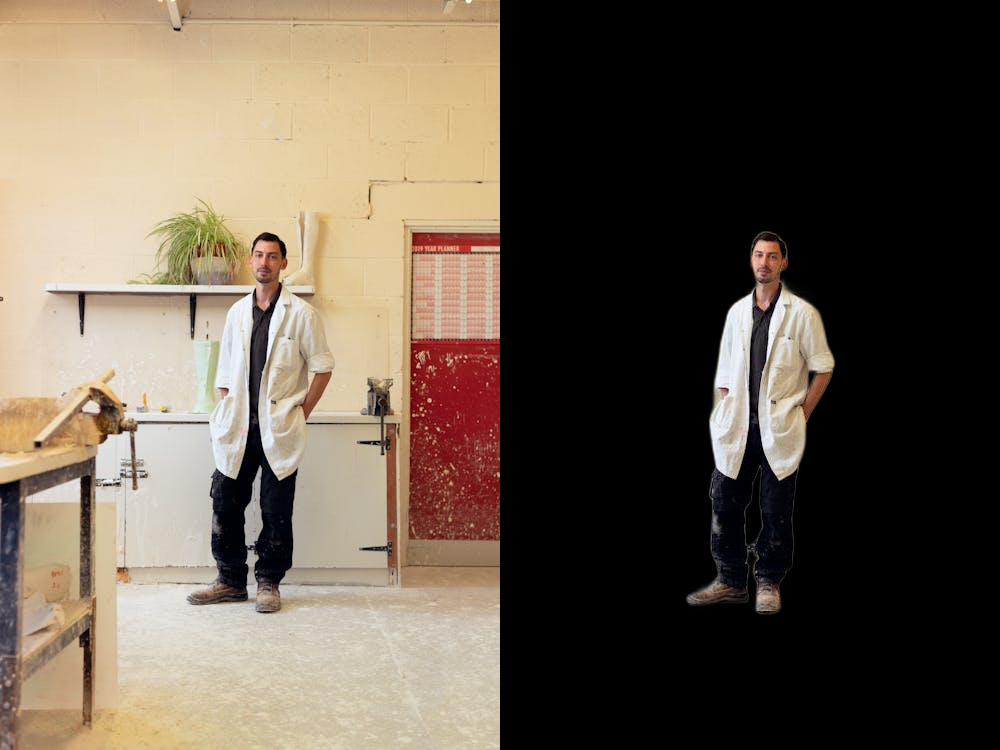

In [ ]:
from rembg import remove
from PIL import Image
import io
from google.colab.patches import cv2_imshow
import cv2
import numpy as np

# Load the image file
input_path = "/content/image_240.jpeg"
output_path = "/content/drive/MyDrive/Lab_Coat_Dataset/Background_Removed_images"  # Save the background-removed image as .jpg

# Open the original image
original_image = Image.open(input_path).convert("RGB")  # Ensure 3 channels (RGB)

# Remove background
with open(input_path, "rb") as img_file:
    input_image = img_file.read()

output_image = remove(input_image)

# Convert the background-removed image from byte stream back to a PIL image
removed_bg_image = Image.open(io.BytesIO(output_image)).convert("RGB")

# Save the background-removed image in JPG format at the desired location
removed_bg_image.save(output_path, "JPEG")

# Convert to numpy array for manipulation
original_image_np = np.array(original_image)
removed_bg_image_np = np.array(removed_bg_image)

# Convert RGB to BGR for both images (for correct display in OpenCV)
original_image_bgr = cv2.cvtColor(original_image_np, cv2.COLOR_RGB2BGR)
removed_bg_image_bgr = cv2.cvtColor(removed_bg_image_np, cv2.COLOR_RGB2BGR)

# Combine both images horizontally for side-by-side comparison
combined_image = np.hstack((original_image_bgr, removed_bg_image_bgr))

# Show the combined image using OpenCV
cv2_imshow(combined_image)


100%|████████████████████████████████████████| 176M/176M [00:00<00:00, 126GB/s]


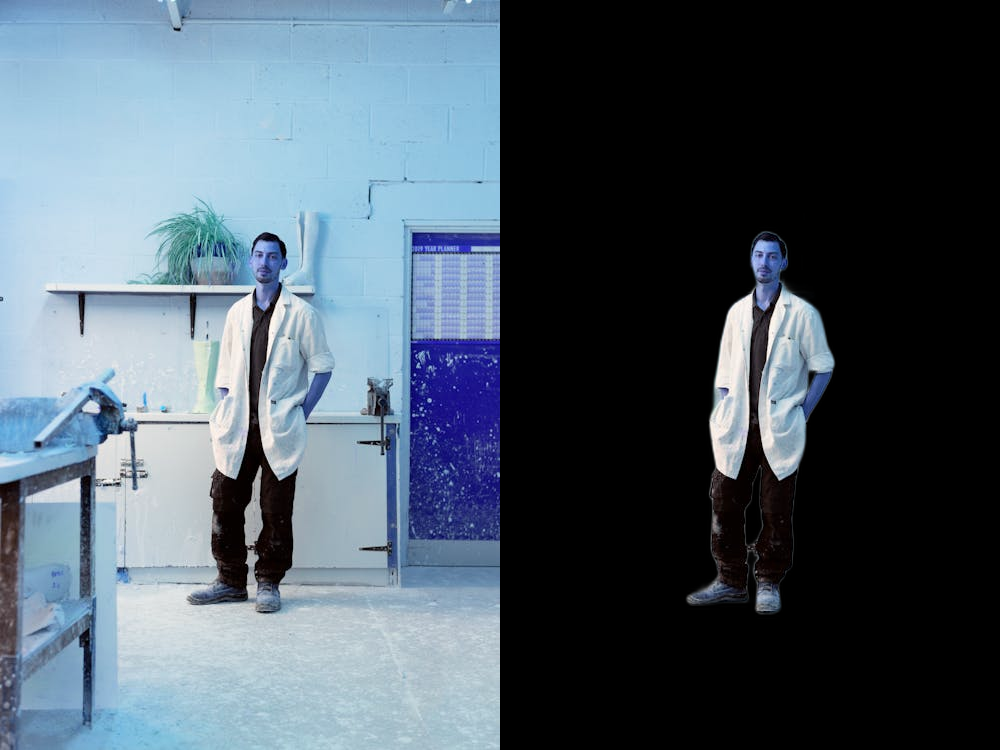

In [ ]:
from rembg import remove
from PIL import Image
import io
from google.colab.patches import cv2_imshow
import cv2
import numpy as np

# Load the image file
input_path = "/content/image_240.jpeg"
output_path = "/content/drive/MyDrive/image.png"

# Open the original image
original_image = Image.open(input_path).convert("RGB")  # Ensure 3 channels (RGB)

# Remove background
with open(input_path, "rb") as img_file:
    input_image = img_file.read()

output_image = remove(input_image)

# Save the result
with open(output_path, "wb") as output_file:
    output_file.write(output_image)

# Convert to numpy array for manipulation
original_image_np = np.array(original_image)

# Load the background-removed image and ensure it has 3 channels (remove alpha channel)
removed_bg_image = Image.open(io.BytesIO(output_image)).convert("RGB")
removed_bg_image_np = np.array(removed_bg_image)

# Combine both images horizontally for side-by-side comparison
combined_image = np.hstack((original_image_np, removed_bg_image_np))

# Show the combined image using OpenCV
cv2_imshow(combined_image)


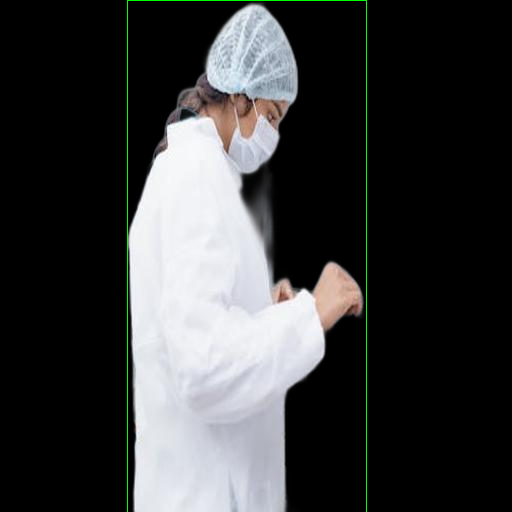

True

In [ ]:
from rembg import remove
from PIL import Image
import io
from google.colab.patches import cv2_imshow
import cv2
import numpy as np

# Load the image file
input_path = "/content/drive/MyDrive/Lab_Coat_Dataset/Resized_Lab_Coat_Images/image_101.jpeg"
output_path = "/content/drive/MyDrive/Lab_Coat_Dataset/removed_bg_image.jpg"  # Save the background-removed image as .jpg

# Open the original image
original_image = Image.open(input_path).convert("RGB")  # Ensure 3 channels (RGB)

# Remove background
with open(input_path, "rb") as img_file:
    input_image = img_file.read()

output_image = remove(input_image)

# Convert the background-removed image from byte stream back to a PIL image
removed_bg_image = Image.open(io.BytesIO(output_image)).convert("RGB")

# Save the background-removed image in JPG format at the desired location
removed_bg_image.save(output_path, "JPEG")

# Convert to numpy array for manipulation
removed_bg_image_np = np.array(removed_bg_image)

# Convert the image to grayscale to identify the non-black region
gray = cv2.cvtColor(removed_bg_image_np, cv2.COLOR_RGB2GRAY)

# Threshold the grayscale image to create a binary image (object vs background)
_, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

# Find contours to detect the bounding box around the object (lab coat)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the largest contour, assuming it corresponds to the object
if contours:
    largest_contour = max(contours, key=cv2.contourArea)

    # Get bounding box coordinates for the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Draw a green bounding box with the adjusted position and height
    cv2.rectangle(removed_bg_image_np, (x, y), (x + w, y + h), (0, 255, 0), 1)  # Thickness of 1
    # Store bounding box coordinates
    bbox = (x, y, w, h)

# Convert RGB to BGR for correct display in OpenCV
removed_bg_image_bgr = cv2.cvtColor(removed_bg_image_np, cv2.COLOR_RGB2BGR)

# Show the image with the bounding box
cv2_imshow(removed_bg_image_bgr)

# Optionally, save the image with the bounding box drawn
output_with_box_path = "/content/drive/MyDrive/Lab_Coat_Dataset/removed_bg_with_box.jpg"
cv2.imwrite(output_with_box_path, removed_bg_image_bgr)

# Now the new coordinates (x, y, w, h) contain the adjusted bounding box
# These can be used later for further operations.


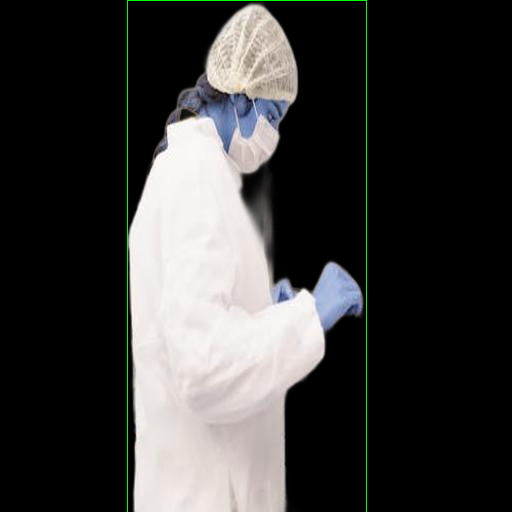

In [ ]:
# Test with a single image
input_path = "/content/drive/MyDrive/Lab_Coat_Dataset/Resized_Lab_Coat_Images/image_101.jpeg"

# Open the original image
original_image = Image.open(input_path).convert("RGB")

# Remove background
with open(input_path, "rb") as img_file:
    input_image = img_file.read()

output_image = remove(input_image)

# Convert to numpy array
removed_bg_image_np = np.array(Image.open(io.BytesIO(output_image)).convert("RGB"))

# Further operations (grayscale, threshold, bounding box) as before
gray = cv2.cvtColor(removed_bg_image_np, cv2.COLOR_RGB2GRAY)
_, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

if contours:
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    cv2.rectangle(removed_bg_image_np, (x, y), (x + w, y + h), (0, 255, 0), 1)

cv2_imshow(removed_bg_image_np)


Bounding Boxes: [('image_3.jpeg', (93, 139, 209, 123)), ('image_4.jpeg', (0, 172, 488, 245)), ('image_11.jpeg', (186, 48, 289, 464)), ('image_12.jpeg', (0, 23, 512, 489)), ('image_13.jpeg', (130, 132, 289, 380)), ('image_15.jpeg', (18, 135, 388, 377)), ('image_18.jpeg', (216, 77, 296, 435)), ('image_22.jpeg', (43, 75, 393, 437)), ('image_24.jpeg', (0, 50, 501, 462)), ('image_26.jpeg', (112, 18, 373, 329)), ('image_31.jpeg', (86, 106, 300, 406)), ('image_33.jpeg', (0, 34, 504, 478)), ('image_36.jpeg', (25, 28, 436, 484)), ('image_37.jpeg', (42, 16, 384, 363)), ('image_43.jpeg', (8, 61, 477, 451)), ('image_52.jpeg', (65, 63, 266, 449)), ('image_57.jpeg', (197, 35, 251, 477)), ('image_66.jpeg', (0, 15, 512, 497)), ('image_82.jpeg', (37, 51, 440, 461)), ('image_83.jpeg', (112, 29, 168, 483)), ('image_86.jpeg', (99, 0, 289, 512)), ('image_98.jpeg', (0, 56, 512, 456)), ('image_101.jpeg', (127, 0, 239, 512)), ('image_105.jpeg', (175, 0, 337, 184)), ('image_112.jpeg', (0, 18, 512, 494)), ('ima

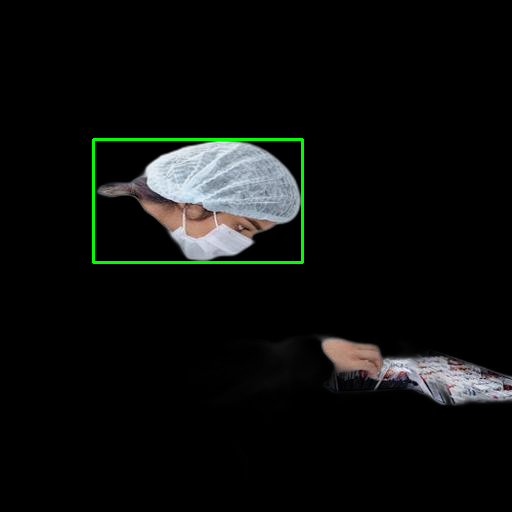

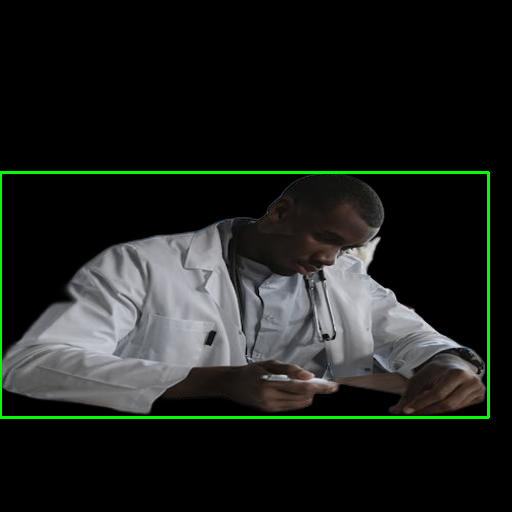

NameError: name 'gray' is not defined

In [ ]:
from rembg import remove
from PIL import Image
import io
import cv2
import numpy as np
import os
import gc

# Define input folder
input_folder = "/content/drive/MyDrive/Lab_Coat_Dataset/Resized_Lab_Coat_Images"
removed_bg_images = []
bounding_boxes = []

# Function to process each image
def process_image(image_name):
    input_path = os.path.join(input_folder, image_name)
    with open(input_path, "rb") as img_file:
        input_image = img_file.read()

    # Remove background using rembg
    output_image = remove(input_image)

    # Convert the background-removed image from byte stream to PIL image
    removed_bg_image = Image.open(io.BytesIO(output_image)).convert("RGB")

    return removed_bg_image

# Step 1: Background Removal for the first image
first_image_name = os.listdir(input_folder)[0]
if first_image_name.endswith('.jpeg'):
    removed_bg_image_first = process_image(first_image_name)
    removed_bg_images.append((first_image_name, removed_bg_image_first))

    # Collect garbage to free up memory after the first image
    gc.collect()

# Step 2: Background Removal for remaining images
for image_name in os.listdir(input_folder)[1:]:  # Skip the first image
    if image_name.endswith('.jpeg'):
        removed_bg_image = process_image(image_name)
        removed_bg_images.append((image_name, removed_bg_image))

        # Collect garbage to free up memory after each image
        gc.collect()

# Step 3: Bounding Box Detection
for image_name, removed_bg_image in removed_bg_images:
    removed_bg_image_np = np.array(removed_bg_image)

    # Convert the image to grayscale
    gray = cv2.cvtColor(removed_bg_image_np, cv2.COLOR_RGB2GRAY)

    # Threshold to create a binary image
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

    # Find contours to detect the bounding box
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)

        # Store bounding box coordinates as (image_name, bounding_box)
        bounding_boxes.append((image_name, (x, y, w, h)))

# Print bounding boxes for verification
print("Bounding Boxes:", bounding_boxes)

# Display first few images for verification
from google.colab.patches import cv2_imshow

for image_name, removed_bg_image in removed_bg_images:
    removed_bg_image_np = np.array(removed_bg_image)

    # Get corresponding bounding box
    bbox = next((box for name, box in bounding_boxes if name == image_name), None)

    if bbox:
        x, y, w, h = bbox
        # Draw bounding box on the image
        cv2.rectangle(removed_bg_image_np, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Convert RGB to BGR for OpenCV display
    removed_bg_image_bgr = cv2.cvtColor(removed_bg_image_np, cv2.COLOR_RGB2BGR)

    # Display the image with bounding box
    cv2_imshow(removed_bg_image_bgr)

    # Clear variables for the next iteration
    del removed_bg_image_np, gray, thresh, contours, largest_contour, output_image
    gc.collect()


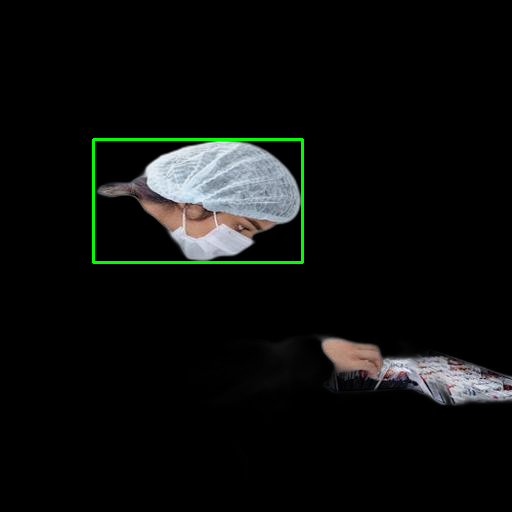

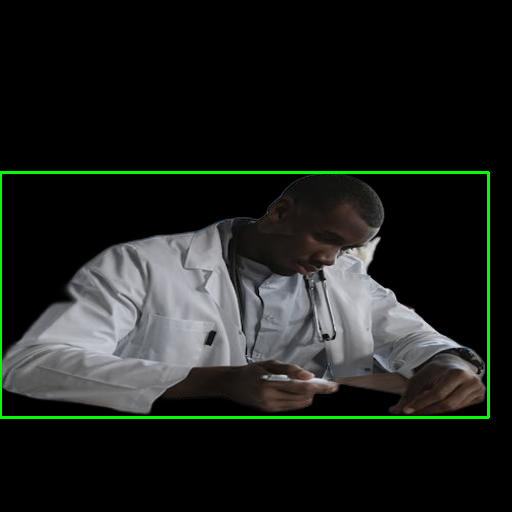

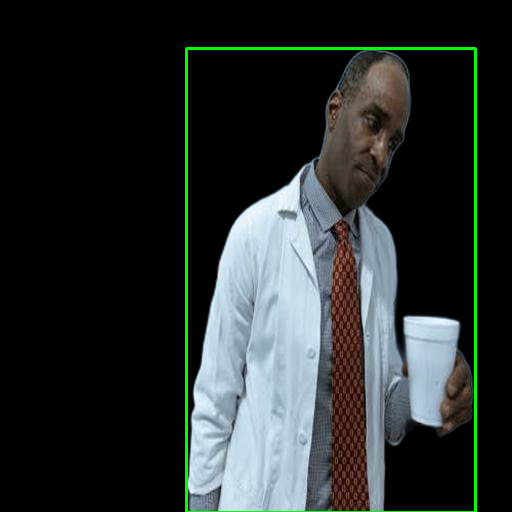

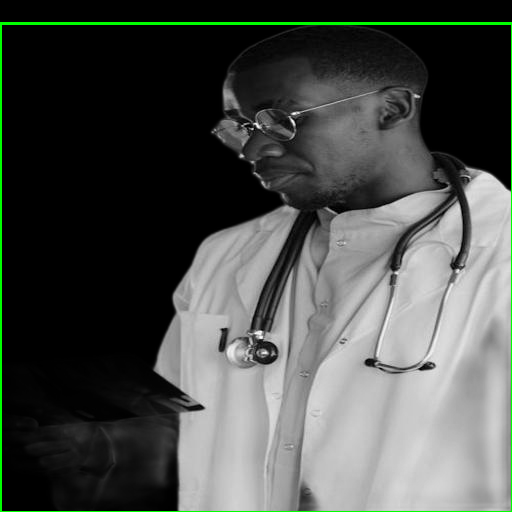

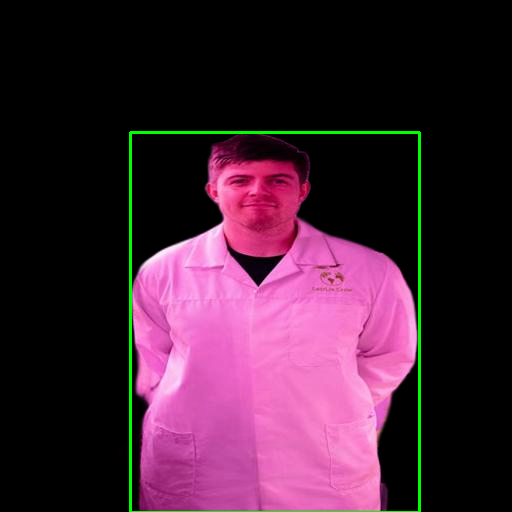

Bounding Boxes: [('image_3.jpeg', (93, 139, 209, 123)), ('image_4.jpeg', (0, 172, 488, 245)), ('image_11.jpeg', (186, 48, 289, 464)), ('image_12.jpeg', (0, 23, 512, 489)), ('image_13.jpeg', (130, 132, 289, 380)), ('image_15.jpeg', (18, 135, 388, 377)), ('image_18.jpeg', (216, 77, 296, 435)), ('image_22.jpeg', (43, 75, 393, 437)), ('image_24.jpeg', (0, 50, 501, 462)), ('image_26.jpeg', (112, 18, 373, 329)), ('image_31.jpeg', (86, 106, 300, 406)), ('image_33.jpeg', (0, 34, 504, 478)), ('image_36.jpeg', (25, 28, 436, 484)), ('image_37.jpeg', (42, 16, 384, 363)), ('image_43.jpeg', (8, 61, 477, 451)), ('image_52.jpeg', (65, 63, 266, 449)), ('image_57.jpeg', (197, 35, 251, 477)), ('image_66.jpeg', (0, 15, 512, 497)), ('image_82.jpeg', (37, 51, 440, 461)), ('image_83.jpeg', (112, 29, 168, 483)), ('image_86.jpeg', (99, 0, 289, 512)), ('image_98.jpeg', (0, 56, 512, 456)), ('image_101.jpeg', (127, 0, 239, 512)), ('image_105.jpeg', (175, 0, 337, 184)), ('image_112.jpeg', (0, 18, 512, 494)), ('ima

In [ ]:
from rembg import remove
from PIL import Image
import io
import cv2
import numpy as np
import os
import gc  # Garbage collection to free memory
import time

# Define input folder and number of images to display
input_folder = "/content/drive/MyDrive/Lab_Coat_Dataset/Resized_Lab_Coat_Images"
num_display_images = 5  # Number of images to display for verification
removed_bg_images = []

# Function to process each image in isolation
def process_image(image_name):
    input_path = os.path.join(input_folder, image_name)
    with open(input_path, "rb") as img_file:
        input_image = img_file.read()

    # Remove background using rembg
    output_image = remove(input_image)

    # Convert the background-removed image from byte stream to PIL image
    removed_bg_image = Image.open(io.BytesIO(output_image)).convert("RGB")

    return (image_name, removed_bg_image)

# Step 1: Background Removal for all images
for image_name in os.listdir(input_folder):
    if image_name.endswith('.jpeg'):
        # Process each image one by one
        removed_bg_image = process_image(image_name)
        removed_bg_images.append(removed_bg_image)

        # Collect garbage to free up memory after each image
        gc.collect()

        # Add a delay between processing each image
        time.sleep(0.5)  # 0.5-second delay

# Step 2: Bounding Box Detection
bounding_boxes = []

for image_name, removed_bg_image in removed_bg_images:
    removed_bg_image_np = np.array(removed_bg_image)

    # Convert the image to grayscale
    gray = cv2.cvtColor(removed_bg_image_np, cv2.COLOR_RGB2GRAY)

    # Threshold to create a binary image
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

    # Find contours to detect the bounding box
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)

        # Store bounding box coordinates as (image_name, bounding_box)
        bounding_boxes.append((image_name, (x, y, w, h)))

# Display first few images with bounding boxes for verification
for i, (image_name, removed_bg_image) in enumerate(removed_bg_images):
    if i >= num_display_images:
        break

    removed_bg_image_np = np.array(removed_bg_image)

    # Get corresponding bounding box
    bbox = next((box for name, box in bounding_boxes if name == image_name), None)

    if bbox:
        x, y, w, h = bbox
        # Draw bounding box on the image
        cv2.rectangle(removed_bg_image_np, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Convert RGB to BGR for OpenCV display
    removed_bg_image_bgr = cv2.cvtColor(removed_bg_image_np, cv2.COLOR_RGB2BGR)

    # Display the image with bounding box
    from google.colab.patches import cv2_imshow
    cv2_imshow(removed_bg_image_bgr)

# Print bounding boxes for verification
print("Bounding Boxes:", bounding_boxes)


In [ ]:
bbox

(127, 0, 239, 512)

In [ ]:
print(x, y, w, h)

149 85 249 382


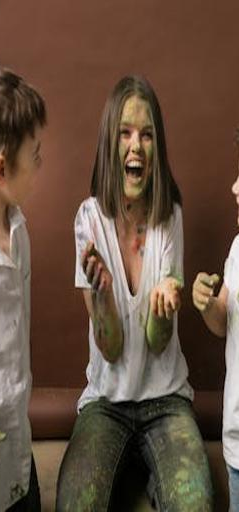

Max x: 366, Max y: 512


In [ ]:
import cv2
from google.colab.patches import cv2_imshow

# Load the image
image_path = '/content/drive/MyDrive/Lab_Coat_Dataset/train_folder/train_images/image_101.jpg'  # Replace with your image path
image = cv2.imread(image_path)

# Define the bounding box coordinates (x, y, w, h)
bounding_box = (127, 0, 239, 512)  # Replace with your (x, y, w, h) coordinates

# Extract the region of interest
x, y, w, h = bounding_box
x_max = x + w  # Calculate x_max
y_max = y + h  # Calculate y_max

# Extract the bounding box region
roi = image[y:y_max, x:x_max]  # Extract the region using (x, y, w, h)

# Display the extracted region
cv2_imshow(roi)

# Print max x and y for reference
print(f'Max x: {x_max}, Max y: {y_max}')


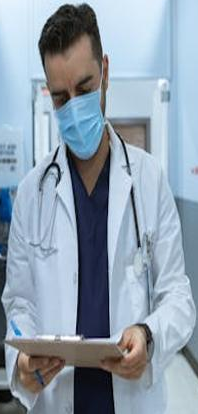

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

# Load the image
image_path = '/content/drive/MyDrive/Lab_Coat_Dataset/train_folder/train_images/image_82.jpg'  # Replace with your image path
image = cv2.imread(image_path)

# Define the bounding box coordinates
# Example: (x_min, y_min, x_max, y_max)
bounding_box = (190,
                48,
                388,
                462)  # Replace with your bounding box coordinates

# Extract the region of interest
x_min, y_min, x_max, y_max = bounding_box
roi = image[y_min:y_max, x_min:x_max]  # Extract the bounding box region

# Display the extracted region
cv2_imshow(roi)



In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!pip install rembg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.7 MB/s eta 0:00:00


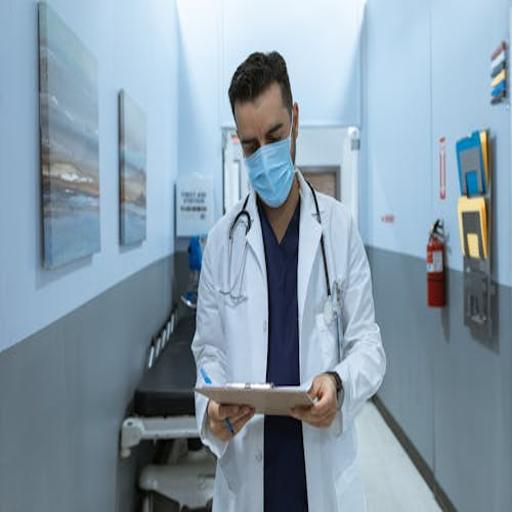

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

# Load the image
image_path = '/content/drive/MyDrive/Lab_Coat_Dataset/train_folder/train_images/image_82.jpg'  # Replace with your image path
image = cv2.imread(image_path)

# Define the bounding box values (x, y, w, h)
bounding_box = (190, 48, 198, 414)  # Replace with your bounding box values (x, y, width, height)

# Extract the region of interest using the bounding box
x, y, w, h = bounding_box
roi = image[y:y+h, x:x+w]  # Extract the bounding box region

# Optional: You can modify the ROI if needed
# For example, here we are just converting it to grayscale
# roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

# Put the extracted ROI back onto the original image
image[y:y+h, x:x+w] = roi

# Display the original image with the ROI placed back
cv2_imshow(image)
